# Titanic Disaster -- Who survived and who did not?

This project aims at developing a model that predicts the fate of each passenger on the famous RMS Titanic that met a disaster and sank in Atalntic Ocean on 15 April 1912. The objective of this project is to take part in a modelling competetion hosted on the website [Kaggle](https://www.kaggle.com/c/titanic) as part of the learning exercise. The model is trained on the data set in the *train.csv* file using a subset of the given variables except **_survived_** variable which is the target variable. Once the model is developed, it will be used to predict the target variable from the data set in *test.csv* file and submit the resultant predictions to Kaggle in the format as provided in the *gender_submission.csv* file.

## Load the data set and import libraries
Lets load the data sets and import the libraries.

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import matplotlib.pyplot as plt
%matplotlib inline


titanic_df = pd.read_csv('data/train.csv')
titanic_df['data'] = 'train'
titanic_test = pd.read_csv('data/test.csv')
titanic_test['data'] = 'test'
titanic_df = titanic_df.append(titanic_test, sort = False, ignore_index = True)
titanic_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,test


Note that we have imported just one performance metric (accuracy score) for this binary classification problem solely because this will be used by Kaggle to judge our model. In general, accuracy is a poor choice in classification problems especially when the problem is not balanced.

In [5]:
titanic_df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
data              0
dtype: int64

In [6]:
titanic_df.Fare.fillna(titanic_df.Fare.mean(), inplace = True)

In [7]:
titanic_df.Embarked.fillna(titanic_df.Embarked.mode(), inplace = True)

In [8]:
titanic_df1 = pd.get_dummies(
    titanic_df
    , columns = ['Pclass', 'SibSp', 'Sex', 'Embarked', 'Parch']
    , drop_first = True
)[['data', 'Fare', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8'
  , 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6'
  , 'Parch_9', 'Survived']]
titanic_df1.tail().transpose()

,1304,1305,1306,1307,1308
data,test,test,test,test,test
Fare,8.05,108.9,7.25,8.05,22.3583
Pclass_2,0,0,0,0,0
Pclass_3,1,0,1,1,1
SibSp_1,0,0,0,0,1
SibSp_2,0,0,0,0,0
SibSp_3,0,0,0,0,0
SibSp_4,0,0,0,0,0
SibSp_5,0,0,0,0,0
SibSp_8,0,0,0,0,0


In [9]:
train_df = titanic_df1[titanic_df1['data'] == 'train'].drop(labels = ['data'], axis = 1)
train_df.tail().transpose()

,886,887,888,889,890
Fare,13.0,30.0,23.45,30.0,7.75
Pclass_2,1.0,0.0,0.00,0.0,0.00
Pclass_3,0.0,0.0,1.00,0.0,1.00
SibSp_1,0.0,0.0,1.00,0.0,0.00
SibSp_2,0.0,0.0,0.00,0.0,0.00
SibSp_3,0.0,0.0,0.00,0.0,0.00
SibSp_4,0.0,0.0,0.00,0.0,0.00
SibSp_5,0.0,0.0,0.00,0.0,0.00
SibSp_8,0.0,0.0,0.00,0.0,0.00
Sex_male,1.0,0.0,0.00,1.0,1.00


In [10]:
test_df = titanic_df1[titanic_df1['data'] == 'test'].drop(labels = ['data', 'Survived'], axis = 1)
test_df.tail().transpose()

,1304,1305,1306,1307,1308
Fare,8.05,108.9,7.25,8.05,22.3583
Pclass_2,0.00,0.0,0.00,0.00,0.0000
Pclass_3,1.00,0.0,1.00,1.00,1.0000
SibSp_1,0.00,0.0,0.00,0.00,1.0000
SibSp_2,0.00,0.0,0.00,0.00,0.0000
SibSp_3,0.00,0.0,0.00,0.00,0.0000
SibSp_4,0.00,0.0,0.00,0.00,0.0000
SibSp_5,0.00,0.0,0.00,0.00,0.0000
SibSp_8,0.00,0.0,0.00,0.00,0.0000
Sex_male,1.00,0.0,1.00,1.00,1.0000


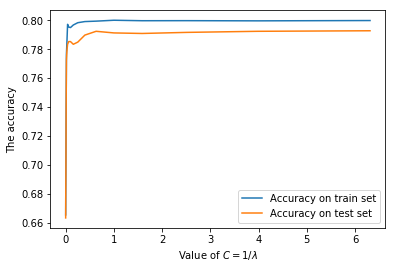

Best C: 6.309573444801933
Best Score: 0.7927422371866817


In [11]:
C = np.logspace(-4, 0.8, 25)
hyperparameters = dict(C = C)
lreg = LogisticRegression(penalty = 'l2', max_iter = 10000, tol = 0.001, solver = 'lbfgs')
cv = RepeatedKFold(n_splits=10, n_repeats = 3)
grid_lreg = GridSearchCV(lreg
                        , hyperparameters
                        , cv = cv
                        , verbose = 0
                        , scoring = 'accuracy'
                        , return_train_score = True)
grid_lreg.fit(train_df.drop(labels = ['Survived'], axis = 1), train_df['Survived'])

plt.plot(C, grid_lreg.cv_results_['mean_train_score'], label = 'Accuracy on train set')
plt.plot(C, grid_lreg.cv_results_['mean_test_score'], label = 'Accuracy on test set')
plt.legend()
plt.xlabel('Value of $C=1/\lambda $')
plt.ylabel("The accuracy")
plt.show()

print('Best C:', grid_lreg.best_estimator_.get_params()['C'])
print('Best Score:', grid_lreg.best_score_)

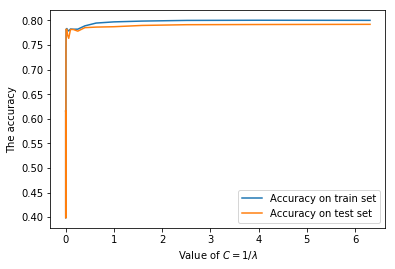

Best C: 6.309573444801933
Best Score: 0.7919940142162364


In [12]:
lreg1 = LogisticRegression(penalty = 'l1', max_iter = 10000, tol = 0.001, solver = 'liblinear')
grid_lreg1 = GridSearchCV(lreg1
                        , hyperparameters
                        , cv = cv
                        , verbose = 0
                        , scoring = 'accuracy'
                        , return_train_score = True)
grid_lreg1.fit(train_df.drop(labels = ['Survived'], axis = 1), train_df['Survived'])

plt.plot(C, grid_lreg1.cv_results_['mean_train_score'], label = 'Accuracy on train set')
plt.plot(C, grid_lreg1.cv_results_['mean_test_score'], label = 'Accuracy on test set')
plt.legend()
plt.xlabel('Value of $C=1/\lambda $')
plt.ylabel("The accuracy")
plt.show()

print('Best C:', grid_lreg1.best_estimator_.get_params()['C'])
print('Best Score:', grid_lreg1.best_score_)

In [13]:
# Install xgboost in notebook instance.
#### Command to install xgboost
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    py-xgboost-0.82            |   py36he1b5a44_0          70 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    xgboost-0.82               |   py36he1b5a44_0           9 KB  conda-forge
    libxgboost-0.82            |       he1b5a44_0         3.9 MB  conda-forge
    -------------------------------------------------

In [14]:
import xgboost as xgb

In [15]:
classifier = xgb.XGBClassifier()

In [16]:
classifier.fit(train_df.drop(labels = ['Survived'], axis = 1), train_df['Survived'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
y_pred = classifier.predict(test_df)

In [18]:
y_pred

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [19]:
test_df.head()

,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Sex_male,Embarked_Q,Embarked_S,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
891,7.8292,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
892,7.0000,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
893,9.6875,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
894,8.6625,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
895,12.2875,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [20]:
test_df['Survived'] = y_pred

In [21]:
test_df.head()

,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Sex_male,Embarked_Q,Embarked_S,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Survived
891,7.8292,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.0
892,7.0000,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
893,9.6875,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.0
894,8.6625,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0.0
895,12.2875,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1.0


In [22]:
test_df.columns

Index(['Fare', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Parch_9', 'Survived'],
      dtype='object')

In [23]:
test_df = test_df[['Survived', 'Fare', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2', 'SibSp_3',
       'SibSp_4', 'SibSp_5', 'SibSp_8', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Parch_9']]

In [24]:
test_df.head()

,Survived,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Sex_male,Embarked_Q,Embarked_S,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
891,0.0,7.8292,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
892,0.0,7.0000,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
893,0.0,9.6875,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
894,0.0,8.6625,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
895,1.0,12.2875,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [25]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [26]:
titanic_test = titanic_df[titanic_df['data']=='test']

In [27]:
titanic_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test
893,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test
894,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test
895,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test


In [30]:
titanic_xgboost_test = titanic_test[['PassengerId', 'Survived']]

In [31]:
titanic_xgboost_test.head()

,PassengerId,Survived
891,892,0.0
892,893,0.0
893,894,0.0
894,895,0.0
895,896,1.0


In [32]:
titanic_xgboost_test.to_csv('Titanic_test.csv', index=False)